# DiffEqBiological Tutorial I; Introduction
### Samuel Isaacson

DiffEqBiological.jl is a domain specific language (DSL) for writing chemical reaction networks in Julia. The generated chemical reaction network model can then be translated into a variety of mathematical models which can be solved using components of the broader DifferentialEquations.jl ecosystem.

In this tutorial we'll provide an introduction to using DiffEqBiological to specify chemical reaction networks, and then to solve ODE, jump, tau-leaping and SDE models generated from them. Let's start by using the DiffEqBiological `reaction_network` macro to specify a simply chemical reaction network; the well-known Repressilator. 

We first import the basic packages we'll need, and use PyPlot for making figures:

In [1]:
# If not already installed, first hit "]" within a Julia REPL. Then type:
# add DifferentialEquations DiffEqBiological PyPlot Plots Latexify 

using DifferentialEquations, DiffEqBiological, Plots, Latexify
pyplot(fmt=:svg);

We now construct the reaction network. The basic types of arrows and predefined rate laws one can use are discussed in detail within the DiffEqBiological [documentation](http://docs.juliadiffeq.org/latest/models/biological.html). Here we use a mix of first order, zero order and repressive Hill function rate laws. Note, $\varnothing$ corresponds to the empty state, and is used for zeroth order production and first order degradation reactions:

In [2]:
repressilator = @reaction_network begin
    hillr(P₃,α,K,n), ∅ --> m₁
    hillr(P₁,α,K,n), ∅ --> m₂
    hillr(P₂,α,K,n), ∅ --> m₃
    (δ,γ), m₁ ↔ ∅
    (δ,γ), m₂ ↔ ∅
    (δ,γ), m₃ ↔ ∅
    β, m₁ --> m₁ + P₁
    β, m₂ --> m₂ + P₂
    β, m₃ --> m₃ + P₃
    μ, P₁ --> ∅
    μ, P₂ --> ∅
    μ, P₃ --> ∅
end α K n δ γ β μ;

We can use Latexify to look at the corresponding reactions and understand the generated rate laws for each reaction

In [3]:
latexify(repressilator; env=:chemical)

L"\begin{align}
\require{mhchem}
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_3^{n}}] m_{1}}\\
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_1^{n}}] m_{2}}\\
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_2^{n}}] m_{3}}\\
\ce{ m_{1} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{2} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{3} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{1} &->[\beta] m_{1} + P_{1}}\\
\ce{ m_{2} &->[\beta] m_{2} + P_{2}}\\
\ce{ m_{3} &->[\beta] m_{3} + P_{3}}\\
\ce{ P_{1} &->[\mu] \varnothing}\\
\ce{ P_{2} &->[\mu] \varnothing}\\
\ce{ P_{3} &->[\mu] \varnothing}
\end{align}
"

We can also use Latexify to look at the corresponding ODE model for the chemical system

In [4]:
latexify(repressilator)

L"\begin{align}
\frac{dm_1}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_3^{n}} - \delta \cdot m_1 + \gamma \\
\frac{dm_2}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_1^{n}} - \delta \cdot m_2 + \gamma \\
\frac{dm_3}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_2^{n}} - \delta \cdot m_3 + \gamma \\
\frac{dP_1}{dt} =& \beta \cdot m_1 - \mu \cdot P_1 \\
\frac{dP_2}{dt} =& \beta \cdot m_2 - \mu \cdot P_2 \\
\frac{dP_3}{dt} =& \beta \cdot m_3 - \mu \cdot P_3 \\
\end{align}
"

To solve the ODEs we need to specify the values of the parameters in the model, the initial condition, and the time interval to solve the model on. To do this it helps to know the orderings of the parameters and the species. Parameters are ordered in the same order they appear after the `end` statement in the `@reaction_network` macro. Species are ordered in the order they first appear within the `@reaction_network` macro. We can see these orderings using the `speciesmap` and `paramsmap` functions:

In [5]:
speciesmap(repressilator)

OrderedCollections.OrderedDict{Symbol,Int64} with 6 entries:
  :m₁ => 1
  :m₂ => 2
  :m₃ => 3
  :P₁ => 4
  :P₂ => 5
  :P₃ => 6

In [6]:
paramsmap(repressilator)

OrderedCollections.OrderedDict{Symbol,Int64} with 7 entries:
  :α => 1
  :K => 2
  :n => 3
  :δ => 4
  :γ => 5
  :β => 6
  :μ => 7

## Solving the ODEs:
Knowing these orderings, we can create parameter and initial condition vectors, and setup the `ODEProblem` we want to solve:

In [16]:
# parameters [α,K,n,δ,γ,β,μ]
p = (.5, 40, 2, log(2)/120, 5e-3, 20*log(2)/120, log(2)/60)

# initial condition [m₁,m₂,m₃,P₁,P₂,P₃]
u₀ = [0.,0.,0.,20.,0.,0.]

# time interval to solve on
tspan = (0., 10000.)

# create the ODEProblem we want to solve
oprob = ODEProblem(repressilator, u₀, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10000.0)
u0: [0.0, 0.0, 0.0, 20.0, 0.0, 0.0]

At this point we are all setup to solve the ODEs. We can now use any ODE solver from within the DiffEq package. We'll just use the default DifferentialEquations solver for now, and then plot the solutions:

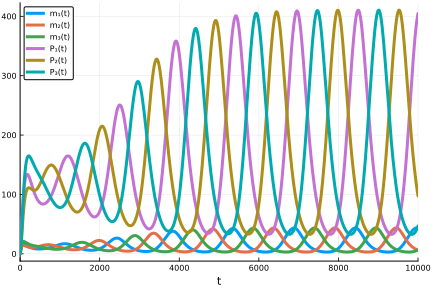

In [17]:
sol = solve(oprob, saveat=10.)
plot(sol, fmt=:svg)

We see the well-known oscillatory behavior of the repressilator! For more on choices of ODE solvers, see the JuliaDiffEq [documentation](http://docs.juliadiffeq.org/latest/solvers/ode_solve.html).

---

## Stochastic Simulation Algorithms (SSAs) for Stochastic Chemical Kinetics
Let's now look at a stochastic version of the repressilator, modeling it with jump processes. Here we will construct a DiffEqJump `JumpProblem` that uses Gillespie's `Direct` method, and then solve it to generate one realization of the jump process:

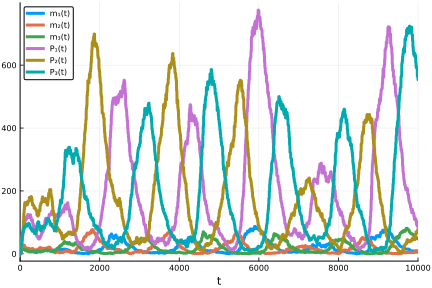

In [18]:
# first we redefine the initial condition to be integer valued
u₀ = [0,0,0,20,0,0]

# next we create a discrete problem to encode that our species are integer valued:
dprob = DiscreteProblem(repressilator, u₀, tspan, p)

# now we create a JumpProblem, and specify Gillespie's Direct Method as the solver:
jprob = JumpProblem(dprob, Direct(), repressilator, save_positions=(false,false))

# now let's solve and plot the jump process:
sol = solve(jprob, SSAStepper(), saveat=10.)
plot(sol, fmt=:svg)

Here we see that oscillations remain, but become much noiser. Note, in constructing the `JumpProblem` we could have used any of the SSAs that are part of DiffEqJump instead of the `Direct` method, see the list of SSAs (i.e. constant rate jump aggregators) in the [documentation](http://docs.juliadiffeq.org/latest/types/jump_types.html#Constant-Rate-Jump-Aggregators-1).

---
## $\tau$-leaping Methods:
While SSAs generate exact realizations for stochastic chemical kinetics jump process models, [$\tau$-leaping](https://en.wikipedia.org/wiki/Tau-leaping) methods offer a performant alternative by discretizing in time the underlying time-change representation of the stochastic process. The DiffEqJump package has limited support for $\tau$-leaping methods in the form of the basic Euler's method type approximation proposed by Gillespie. We can simulate the repressilator by constructing a `JumpProblem` from the `reaction_network.regular_jumps` field:

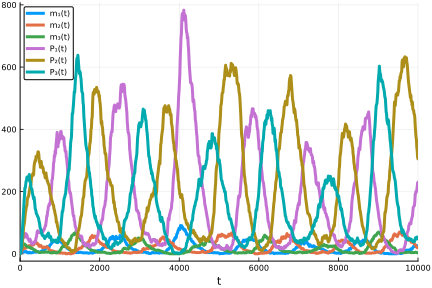

In [10]:
lprob = JumpProblem(dprob, Direct(), repressilator.regular_jumps)
lsol = solve(lprob, SimpleTauLeaping(), dt=.1)
plot(lsol, plotdensity=1000, fmt=:svg)

---
## Chemical Langevin Equation (CLE) Stochastic Differential Equation (SDE) Models:
At an intermediary physical scale between macroscopic ODE models and microscopic stochastic chemical kinetic models lies the CLE, a SDE version of the model. The SDEs add to each ODE above a noise term. As the repressilator has species that get very close to zero in size, it is not a good candidate to model with the CLE (where solutions can then go negative and become unphysical). Let's create a simpler reaction network for a birth-death process that will stay non-negative:

In [11]:
bdp = @reaction_network begin
  c₁, X --> 2X
  c₂, X --> 0
  c₃, 0 --> X
end c₁ c₂ c₃
p = (1.0,2.0,50.)
u₀ = [5.]
tspan = (0.,4.);

The corresponding Chemical Langevin Equation SDE is then
```math
dX_t = \left(c₁ X - c₂ X + c₃ \right) dt + \left( \sqrt{c₁ X} - \sqrt{c₂ X} + \sqrt{c₃} \right)dW_t,
```
where $W_t$ denotes a standard Brownian Motion. We can solve the CLE SDE model by creating an SDEProblem and solving it similar to what we did for ODEs above:

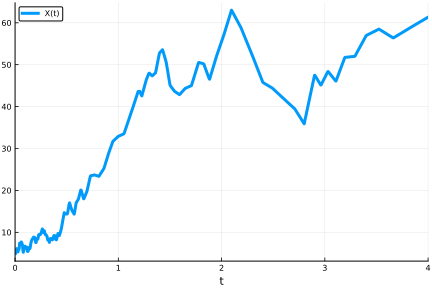

In [12]:
# SDEProblem for CLE
sprob = SDEProblem(bdp, u₀, tspan, p)

# solve and plot
sol = solve(sprob, saveat=.004)
plot(sol, fmt=:svg)

We again have complete freedom to select any of the StochasticDifferentialEquations.jl SDE solvers, see the [documentation](http://docs.juliadiffeq.org/latest/solvers/sde_solve.html).

---
## What information the reaction_network provides:
The generated `reaction_network` contains a lot of basic information. For example
- `repressilator.f` is a function `f(du,u,p,t)` that given the current state vector `u` and time `t` fills `du` with the time derivatives of `u` (i.e. the right hand side of the ODEs).
- `repressilator.jac` is a function `jac(J,u,p,t)` that evaluates and returns the Jacobian of the ODEs in `J`. The corresponding expressions for each Jacobian term are stored in the `symjac` field:

In [13]:
latexify(repressilator.symjac)

L"\begin{equation}
\left[
\begin{array}{cccccc}
 - \delta & 0 & 0 & 0 & 0 & \frac{ - K^{n} \cdot n \cdot \alpha \cdot P_3^{-1 + n}}{\left( K^{n} + P_3^{n} \right)^{2}} \\
0 &  - \delta & 0 & \frac{ - K^{n} \cdot n \cdot \alpha \cdot P_1^{-1 + n}}{\left( K^{n} + P_1^{n} \right)^{2}} & 0 & 0 \\
0 & 0 &  - \delta & 0 & \frac{ - K^{n} \cdot n \cdot \alpha \cdot P_2^{-1 + n}}{\left( K^{n} + P_2^{n} \right)^{2}} & 0 \\
\beta & 0 & 0 &  - \mu & 0 & 0 \\
0 & \beta & 0 & 0 &  - \mu & 0 \\
0 & 0 & \beta & 0 & 0 &  - \mu \\
\end{array}
\right]
\end{equation}
"

- `repressilator.paramjac` is a function `pjac(pJ,u,p,t)` that evaluates and returns the Jacobian, `pJ`, of the ODEs *with respect to the parameters*. This allows `reaction_network`s to be used in the DifferentialEquations.jl local sensitivity analysis package [DiffEqSensitivity](http://docs.juliadiffeq.org/latest/analysis/sensitivity.html).


By default, generated `ODEProblems` will be passed the corresponding Jacobian function, which will then be used within implicit ODE/SDE methods. 

See the [DiffEqBiological documentation](http://docs.juliadiffeq.org/latest/models/biological.html#The-Reaction-Network-Object-1) for a thorough description of the many other fields within the generated network.